### Margin model example

This example shows how to fit the model taking margin of victory into account.

There is a set of convenient functions in `jax_elo.models.margin_model` which we will use for this.

In [1]:
from jax_elo.models.margin_model import fit, calculate_ratings, predict, get_player_skill_history
from jax_elo.utils.data import get_data

/Users/ingramm/miniconda3/envs/tf/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# Change this to where your data is located.
# This uses Jeff Sackmann's dataset, which is available here:
# https://github.com/JeffSackmann/tennis_atp
data = get_data('/Users/ingramm/Projects/tennis/tennis-data/data/sackmann/tennis_atp/')

In [3]:
to_use = data[data['tourney_date'].dt.year >= 2010]
to_use = to_use.dropna(subset=['spw_winner', 'spw_loser'])

In [4]:
# Compute the margin on the % of service points won
margins = to_use['spw_winner'] - to_use['spw_loser']

In [5]:
# Fit the model
params, opt_info = fit(to_use['winner_name'], to_use['loser_name'], margins.values, verbose=True)

theta: {'a1': 0.1, 'a2': array(0.), 'sigma_obs': 0.1, 'cov_mat': DeviceArray([[1.000001]], dtype=float64)}
cov_mat: [[1.000001]]
theta: {'a1': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=0/1)>, 'a2': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=0/1)>, 'sigma_obs': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=0/1)>, 'cov_mat': Traced<ShapedArray(float64[1,1])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[1,1]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[1,1]):JaxprTrace(level=0/1)>}
cov_mat: Traced<ShapedArray(fl

In [6]:
# The optimal parameters are:
params

EloParams(theta={'a1': 0.00014073263116564527, 'a2': array(0.10045493), 'sigma_obs': 0.08406934746789374, 'cov_mat': DeviceArray([[6320.57949562]], dtype=float64)})

In [7]:
# We can calculate the ratings over time:
history_df, rating_dict = calculate_ratings(params, to_use['winner_name'], to_use['loser_name'], margins.values)

 36%|███▌      | 9394/26149 [00:15<00:22, 758.27it/s]


 75%|███████▌  | 19646/26149 [00:33<00:07, 820.46it/s]


100%|██████████| 26149/26149 [00:41<00:00, 625.08it/s]


In [8]:
import pandas as pd

# Combine this with the other df
full_df = to_use.copy()
full_df = full_df.reset_index()
full_df = pd.concat([full_df, history_df], axis=1)

In [9]:
# We can predict matches using the final ratings, which are in rating_dict
predict(rating_dict, params, 'Roger Federer', 'Tennys Sandgren')

0.9312830396727927

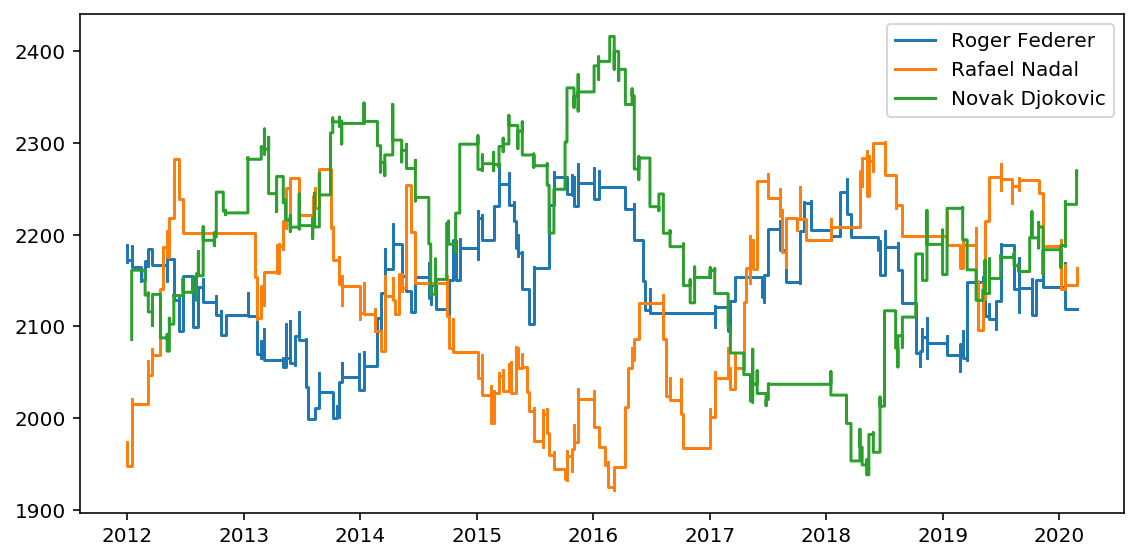

In [10]:
# We can plot the ratings over time
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 1)

start_year = 2012

for cur_player in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:

    history = get_player_skill_history(history_df, rating_dict, full_df['tourney_date'].values, cur_player)
    
    history = history[history.index >= f'{start_year}-01-01']
    ax.step(history.index, history.values, label=cur_player)
    
ax.legend()

f.set_size_inches(8, 4)
f.tight_layout()

In [11]:
# Finally, here's the prior standard deviation:
import numpy as np

prior_sd = np.sqrt(np.squeeze(params.theta['cov_mat']))
print(prior_sd)

79.50207227250705


In [12]:
# How well does this predict?
# This gives the average log probability of the winner
# (aka negative log loss)
np.mean(np.log(history_df['winner_prior_prob']))

-0.5957285854900413

In [13]:
# Accuracy
np.mean(history_df['winner_prior_prob'] > 0.5)

0.6724157711575969

In [14]:
# Compare with Elo:
from jax_elo.utils.elo import optimise_static_k, compute_elo_ratings

In [15]:
k, _ = optimise_static_k(to_use['winner_name'].values, to_use['loser_name'].values)

In [16]:
elo_results = pd.DataFrame(compute_elo_ratings(to_use['winner_name'].values, to_use['loser_name'].values, lambda _: k))

In [17]:
# Standard Elo has a lower log likelihood:
np.mean(np.log(elo_results['winner_prob']))

-0.6032609200891181

In [18]:
# Accuracy
np.mean(elo_results['winner_prob'] > 0.5)

0.6626639642051321